In [44]:
%matplotlib inline
import cartopy.feature
import cartopy.crs as ccrs
# import cartopy
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import xarray as xr
import xesmf as xe
# import random
# from scipy import ndimage
import sys
sys.path.append('../glac1d_meltwater')
import glac1d_toolbox as tb
import routing as routing

# Demonstration routing algorithm

**Objective** : Compute an algorithm that transform the GLAC1D trnsient reconstruction associated with a routing map to a transient meltwater mask given a land sea mask. It will execute the following operations : 
- Transform the ice thickness differences in volumetric fluxes (m -> m3/s, -26,0). Remove negative values.
- Smooth the results. Propose different modes (differential by default)
- Route the ice differences to the associated pointers (conservation of total flux)
- Regrid to HadCM3 grid
- Deal with points overlapping the land sea mask and send them to the closest sea point.

## Inputs

**Land Sea Mask** : The name <-> time table is available on Teams.  

In [38]:
ds_lsm = xr.open_dataset('/nfs/annie/eeymr/work/data/Proj_GLAC1D/lsm/teadv3.qrparm.omask.nc')
lon_hadcm3, lat_hadcm3 = ds_lsm.longitude.values, ds_lsm.latitude.values
lon_hadcm3_b, lat_hadcm3_b = tb.create_coordinate_edges(lon_hadcm3), tb.create_coordinate_edges(lat_hadcm3)
print(ds_lsm)

<xarray.Dataset>
Dimensions:     (latitude: 144, longitude: 288)
Coordinates:
  * longitude   (longitude) float32 0.0 1.25 2.5 3.75 ... 356.25 357.5 358.75
  * latitude    (latitude) float32 -89.375 -88.125 -86.875 ... 88.125 89.375
Data variables:
    lsm         (latitude, longitude) float32 ...
    depthlevel  (latitude, longitude) float32 ...
    depthdepth  (latitude, longitude) float32 ...
Attributes:
    title:    Produced using writenc6 program by PJV


Text(0.5,1,'Land sea mask at 21 kya')

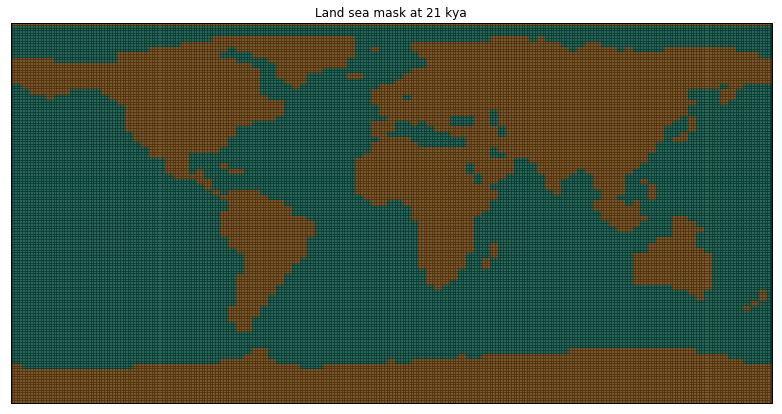

In [43]:
projection_map = ccrs.PlateCarree()

lsm = ds_lsm.lsm.values

figMap,axMap = plt.subplots(nrows=1, ncols=1, subplot_kw={'projection':projection_map}, figsize=(14,7))
cmap = axMap.pcolormesh(lon_hadcm3_b, lat_hadcm3_b, lsm, transform=ccrs.PlateCarree(),cmap="BrBG_r", alpha=0.8)
axMap.set_global()
axMap.set_title("Land sea mask at 21 kya")

**Ice sheet reconstruction** : 2 dimensional time serie of ice thickness (*HGLOBH*)

In [10]:
ds_hice = xr.open_dataset('/nfs/annie/eeymr/work/data/Proj_GLAC1D/routed_fwf/GLAC1DHiceF26.nc')
lon_glac1D, lat_glac1D = ds_hice.XLONGLOBP5.values, ds_hice.YLATGLOBP25.values
lon_glac1D_b, lat_glac1D_b = tb.create_coordinate_edges(lon_glac1D), tb.create_coordinate_edges(lat_glac1D)
print(ds_hice)

<xarray.Dataset>
Dimensions:      (T122KP1: 261, XLONGLOBP5: 720, YLATGLOBP25: 720)
Coordinates:
  * XLONGLOBP5   (XLONGLOBP5) float64 180.2 180.8 181.2 ... 538.8 539.2 539.8
  * YLATGLOBP25  (YLATGLOBP25) float64 -89.88 -89.62 -89.38 ... 89.62 89.88
  * T122KP1      (T122KP1) float64 -26.0 -25.9 -25.8 -25.7 ... -0.2 -0.1 0.0
Data variables:
    HGLOBH       (T122KP1, YLATGLOBP25, XLONGLOBP5) float64 ...
Attributes:
    history:      FERRET V6.96   10-Aug-17
    Conventions:  CF-1.6
    title:        GLAC1D ice thickness Field, Lev Tarasov


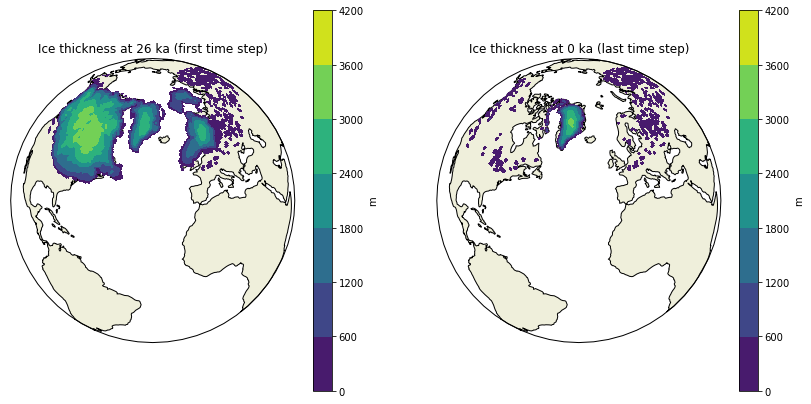

In [15]:
projection_map = ccrs.Orthographic(central_longitude=-30.0, central_latitude=40.0)
figMap,(axStart, axEnd) = plt.subplots(nrows=1, ncols=2, subplot_kw={'projection':projection_map}, figsize=(14,7))

mask_hice_26 = ds_hice.HGLOBH.sel(T122KP1=-26).values
mask_hice_26 = np.where(mask_hice_26==0, np.NAN, mask_hice_26)
cf_26 = axStart.contourf(lon_glac1D, lat_glac1D, mask_hice_26, transform=ccrs.PlateCarree())
axStart.set_global()
axStart.set_title("Ice thickness at 26 ka (first time step)")
axStart.add_feature(cartopy.feature.LAND, zorder=0, edgecolor='black')
figMap.colorbar(mappable=cf_26, ax=axStart, label="m")

mask_hice_0 = ds_hice.HGLOBH.sel(T122KP1=-0).values
mask_hice_0 = np.where(mask_hice_0==0, np.NAN, mask_hice_0)
cf_0 = axEnd.contourf(lon_glac1D, lat_glac1D, mask_hice_0, transform=ccrs.PlateCarree())
axEnd.set_global()
axEnd.set_title("Ice thickness at 0 ka (last time step)")
axEnd.add_feature(cartopy.feature.LAND, zorder=0, edgecolor='black')
figMap.colorbar(mappable=cf_0, ax=axEnd, label="m")

**Ice sheet reconstruction** : 2 dimensional routing map of water basin. *IX* is the longitude index and *JY* is the latitude index, conversion based on provided readme file (*/nfs/annie/eeymr/work/data/Proj_GLAC1D/routed_fwf/GLAC1Dpointer_README.txt*)

In [18]:
ds_pointer = xr.open_dataset('/nfs/annie/eeymr/work/data/Proj_GLAC1D/routed_fwf/GLAC1DdrainagePointerF26ka.nc')
print(ds_pointer)

<xarray.Dataset>
Dimensions:      (T40H1: 261, XLONGLOBP5: 720, YLATGLOBP25: 720)
Coordinates:
  * XLONGLOBP5   (XLONGLOBP5) float64 180.2 180.8 181.2 ... 538.8 539.2 539.8
  * YLATGLOBP25  (YLATGLOBP25) float64 -89.88 -89.62 -89.38 ... 89.62 89.88
  * T40H1        (T40H1) float64 -26.0 -25.9 -25.8 -25.7 ... -0.3 -0.2 -0.1 0.0
Data variables:
    IX           (T40H1, YLATGLOBP25, XLONGLOBP5) float32 ...
    JY           (T40H1, YLATGLOBP25, XLONGLOBP5) float32 ...
Attributes:
    history:      FERRET V6.96   10-Aug-17
    Conventions:  CF-1.6
    title:        GLAC1D drainage Pointer Field, Lev Tarasov


(lon,lat) [index_lon,index_lat] : (275.25, 47.625) [(190, 550)] -> (286.75, 38.375) [(213.0, 513.0)]
(lon,lat) [index_lon,index_lat] : (272.75, 29.375) [(185, 477)] -> (272.75, 29.375) [(185.0, 477.0)]
(lon,lat) [index_lon,index_lat] : (330.25, -64.875) [(300, 100)] -> (330.25, -64.875) [(300.0, 100.0)]


Text(0.5,1,'Sample routing points')

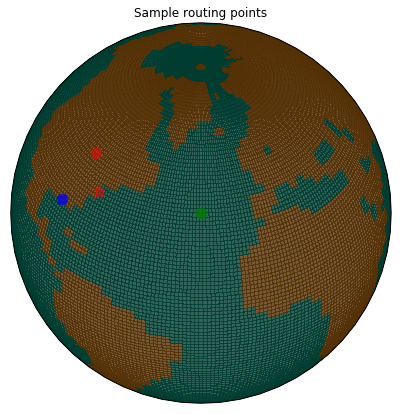

In [42]:
projection_map = ccrs.Orthographic(central_longitude=-30.0, central_latitude=40.0)

# Indexes to coordinates conversion
IX_lon = ds_pointer.IX.sel(T40H1=-26).values*0.5 - 180.25 + 360
JY_lat = 90.125 - ds_pointer.JY.sel(T40H1=-26).values*0.25 

figMap,axMap = plt.subplots(nrows=1, ncols=1, subplot_kw={'projection':projection_map}, figsize=(7,7))

axMap.pcolormesh(lon_hadcm3_b, lat_hadcm3_b, lsm, transform=ccrs.PlateCarree(),cmap="BrBG_r", alpha=0.8)

# Point on land
i, j = 190,550
axMap.scatter(lon_glac1D[i], lat_glac1D[j], transform=ccrs.PlateCarree(), s=100, c="r", alpha=0.5)
axMap.scatter(IX_lon[j,i], JY_lat[j,i], transform=ccrs.PlateCarree(), s=100, c="r", alpha=0.5, marker="X")
i_glac1D, j_glac1D = 2*(IX_lon[j,i] -180.25), 4*(JY_lat[j,i] + 89.875)
print(f"(lon,lat) [index_lon,index_lat] : {lon_glac1D[i], lat_glac1D[j]} [{i,j}] -> {IX_lon[j,i], JY_lat[j,i]} [{i_glac1D, j_glac1D}]")

# Point on the edge of the land sea mask
i, j = 185, 477
axMap.scatter(lon_glac1D[i], lat_glac1D[j], transform=ccrs.PlateCarree(), s=100, c="b", alpha=0.5)
axMap.scatter(IX_lon[j,i], JY_lat[j,i], transform=ccrs.PlateCarree(), s=100, c="b", alpha=0.5, marker="X")
i_glac1D, j_glac1D = 2*(IX_lon[j,i] -180.25), 4*(JY_lat[j,i] + 89.875)
print(f"(lon,lat) [index_lon,index_lat] : {lon_glac1D[i], lat_glac1D[j]} [{i,j}] -> {IX_lon[j,i], JY_lat[j,i]} [{i_glac1D, j_glac1D}]")

# Point in the ocean
i, j = 300,100
axMap.scatter(lon_glac1D[i], lat_glac1D[j], transform=ccrs.PlateCarree(), s=100, c="g", alpha=0.5)
axMap.scatter(IX_lon[j,i], JY_lat[j,i], transform=ccrs.PlateCarree(), s=100, c="g", alpha=0.5, marker="X")
i_glac1D, j_glac1D = 2*(IX_lon[j,i] -180.25), 4*(JY_lat[j,i] + 89.875)
print(f"(lon,lat) [index_lon,index_lat] : {lon_glac1D[i], lat_glac1D[j]} [{i,j}] -> {IX_lon[j,i], JY_lat[j,i]} [{i_glac1D, j_glac1D}]")

axMap.set_global()
axMap.set_title("Sample routing points")

## Conversion and Routing Algoritm

The first thing to do is to convert variation of the ice sheet into a meltwater flux for each points of the icesheet. Then we use the routing map to determine where will this water be released. We show here an example for one time step, but the complete method itterate through time to return a time serie.

In [ ]:
flux = hi_to_discharge(ds_hice, t, mode_flux)

In [45]:
ix, jy = ds_pointer.IX.sel(T40H1=-21).values, ds_pointer.JY.sel(T40H1=-21).values
routed_mask = routing.routing_method(flux, ix, jy)

NameError: name 'flux' is not defined

## Regridding algorithm

The GLAC1D mask doesn't have the same dimension than the HadCM3 files : one should therefore regrid these files to the HadCM3 dimensions. To see a benchmark of the different available methods check misc_demo.